# Install extra dependencies

In [1]:
!pip install -q -U tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00


# Imports

In [2]:
import os
import gc
import time
import copy
import matplotlib.pyplot as plt


import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import defaultdict, Counter
from functools import partial


import keras
import numpy as np
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
import tensorflow_addons as tfa

# Setup Dataset

In [3]:
import os

try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  from google.colab import drive
  drive.mount('/content/drive')
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "gravitational-lensing", "Task6")
  model_save_folder = os.path.join(data_filepath,  "models")
  os.makedirs(model_save_folder, exist_ok=True)

else:
  data_filepath = "data"

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/datasets/ML4SCI_GSOC23/gravitational-lensing/Task6/image_superresolution.zip .
!unzip -q image_superresolution.zip

# Generate Validation Dataset

In [7]:
DEBUG = False

VALIDATION_PORTION = 0.1
files = os.listdir(os.path.join('Dataset', 'HR'))

VAL_FILES = int(len(files) * VALIDATION_PORTION)

print(f"size of whole dataset : {len(files)}")
print(f"size of the training  : {len(files) - VAL_FILES}")
print(f"size of the validaton : {VAL_FILES}")

to_move = np.random.permutation(np.arange(len(files)))[:VAL_FILES]

os.makedirs("Validation",exist_ok=True)
os.makedirs("Validation/HR", exist_ok=True)
os.makedirs("Validation/LR", exist_ok=True)

for idx in tqdm(to_move):
  hr_orig = os.path.join("Dataset", "HR", files[idx])
  lr_orig = os.path.join("Dataset", "LR", files[idx])

  hr_dest = os.path.join("Validation", "HR", files[idx])
  lr_dest = os.path.join("Validation", "LR", files[idx])

  if DEBUG:
    print(f"move {hr_orig} -> {hr_dest}")
    print(f"move {lr_orig} -> {lr_dest}")
  else:
    os.system(f"mv {hr_orig} {hr_dest}")
    os.system(f"mv {lr_orig} {lr_dest}")

print("After move")
print(f"size of training : {len(os.listdir(os.path.join('Dataset', 'HR')))}")
print(f"size of validation : {len(os.listdir(os.path.join('Validation', 'HR')))}")


size of whole dataset : 10000
size of the training  : 9000
size of the validaton : 1000


100%|██████████| 1000/1000 [00:07<00:00, 132.40it/s]

After move
size of training : 9000
size of validation : 1000


# Setup Tensorflow dataset

In [8]:
BATCH_SIZE=16

class LR_HR_DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,  HR_path, LR_path, shuffle=True, batch_size=32):
        self._LR_path_files = [os.path.join(LR_path,v) for v in os.listdir(LR_path)]
        self._HR_path_files = [os.path.join(HR_path,v) for v in os.listdir(HR_path)]
        self.indexes = np.arange(0, len(self._HR_path_files))
        
        self.dim1 = np.load(self._LR_path_files[0]).shape[::-1]
        self.dim2 = np.load(self._HR_path_files[0]).shape[::-1]
        print(f"inferred datatype shape : {self.dim1} {self.dim2}")

        self._shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self._HR_path_files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        LRs, HRs = [self._LR_path_files[k] for k in indexes], [self._HR_path_files[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(LRs, HRs)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self._HR_path_files))
        if self._shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, LRs, HRs):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim1))
        Y = np.empty((self.batch_size, *self.dim2 ))

        # Generate data
        for i, (f1, f2) in enumerate(zip(LRs, HRs)):
            # Store sample
            X[i,] = np.load(f1).transpose(1, 2, 0)

            # Store class
            Y[i,] = np.load(f2).transpose(1, 2, 0)

        return X, Y

# Example usage
train_lr_path = os.path.join("Dataset","LR")
train_hr_path = os.path.join("Dataset","HR")

val_lr_path = os.path.join("Validation","LR")
val_hr_path = os.path.join("Validation","HR")


train_dataset = LR_HR_DataGenerator(train_hr_path, train_lr_path, batch_size=BATCH_SIZE)
val_dataset = LR_HR_DataGenerator(val_hr_path, val_lr_path, batch_size=BATCH_SIZE)

print(f"size of training datset : {len(train_dataset)}")
print(f"size of validation datset : {len(val_dataset)}")

inferred datatype shape : (75, 75, 1) (150, 150, 1)
inferred datatype shape : (75, 75, 1) (150, 150, 1)
size of training datset : 562
size of validation datset : 62


# Keras/tf util functions

In [9]:
def ssim_loss(y_true, y_pred):
    max_val = K.max(y_true)
    min_val = K.min(y_true)
    dynamic_range = max_val - min_val

    ssim_index = tf.image.ssim(y_true, y_pred, max_val=dynamic_range, filter_size=11,
                               filter_sigma=1.5, k1=0.01, k2=0.03)

    # Since SSIM ranges from -1 to 1, and we need a loss function that is minimized, we'll use 1 - SSIM.
    return 1 - K.mean(ssim_index)

def PSNR(y_pred, y_true):
  return tf.image.psnr(y_pred, y_true, 1.)

In [10]:
def eval_model(model, n_vals = 8, s = 8):
  n = next(iter(val_dataset))
  preds = model.predict(n[0])


  for i in range(preds.shape[0])[:n_vals]:
    plt.figure(figsize=(3 * s, s))
    plt.subplot(1, 3, 1)
    plt.title("predicted")
    plt.imshow(preds[i])

    plt.subplot(1, 3, 2)
    plt.title("true")
    plt.imshow(n[1][i])
    
    plt.subplot(1, 3, 3)
    plt.title("$|y_{i} - \hat{y_{i}}|$")
    plt.imshow(np.abs(n[1][i] - preds[i]))

    plt.show()

## Learning rate scheduler

In [11]:
steps_per_epoch = len(train_dataset)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
    maximal_learning_rate=1e-3,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch)

## Callbacks

In [12]:
def getCallbacks(model_name):
  return [
      tf.keras.callbacks.EarlyStopping(patience=2),
      tf.keras.callbacks.ModelCheckpoint(filepath=model_name + '.{epoch:02d}-{val_loss:.2f}.h5'),
      tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  ]

# SRCNN

In [130]:

def create_srcnn():
    model = Sequential()

    # Feature extraction
    model.add(Conv2D(filters=64, kernel_size=(9, 9), activation='relu', padding='same', input_shape=(75, 75, 1)))

    # Non-linear mapping
    model.add(Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same'))

    # UpSampling to increase the resolution (you can also use Conv2DTranspose)
    model.add(UpSampling2D(size=(2, 2)))

    # Reconstruction
    model.add(Conv2D(filters=1, kernel_size=(5, 5), activation='linear', padding='same'))

    return model

model = create_srcnn()
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(clr), loss=ssim_loss, metrics=['mean_squared_error', PSNR])
srcnn_fit = model.fit(train_dataset, epochs=10, callbacks=getCallbacks("SRCNN"), validation_data=val_dataset)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 75, 75, 64)        5248      
                                                                 
 conv2d_67 (Conv2D)          (None, 75, 75, 32)        2080      
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 150, 150, 1)       801       
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
562/562 [==============================] - 15s 24ms/step - loss: 0.0473 - mean_squared_error: 7.2217e-04 -

1/1 [==============================] - 0s 22ms/step


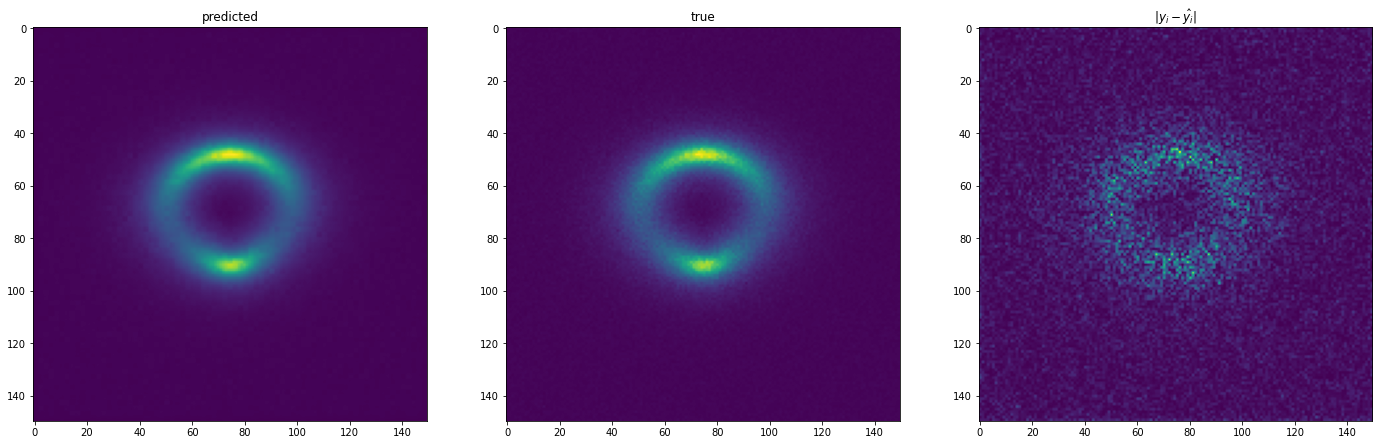

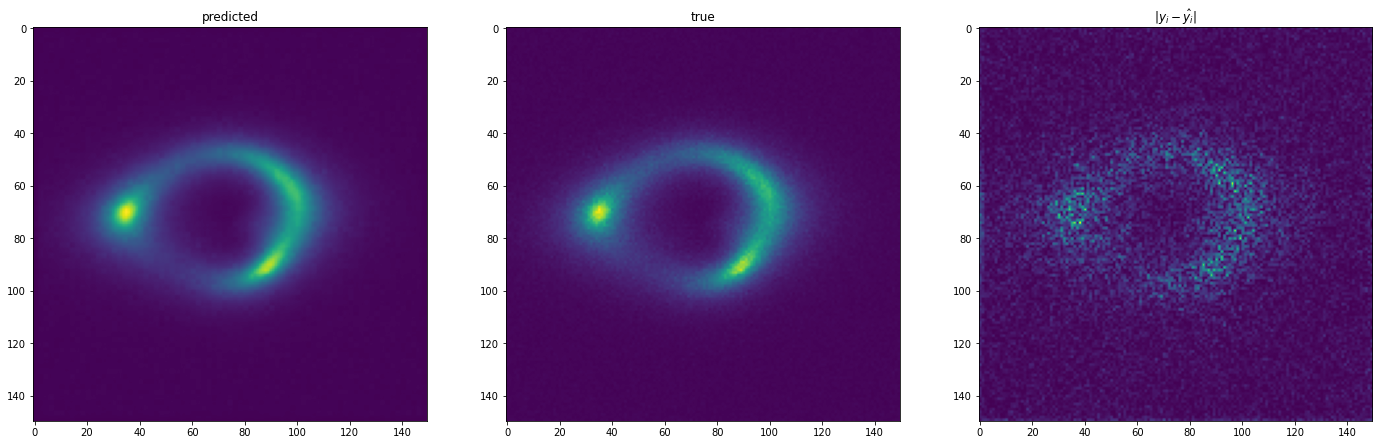

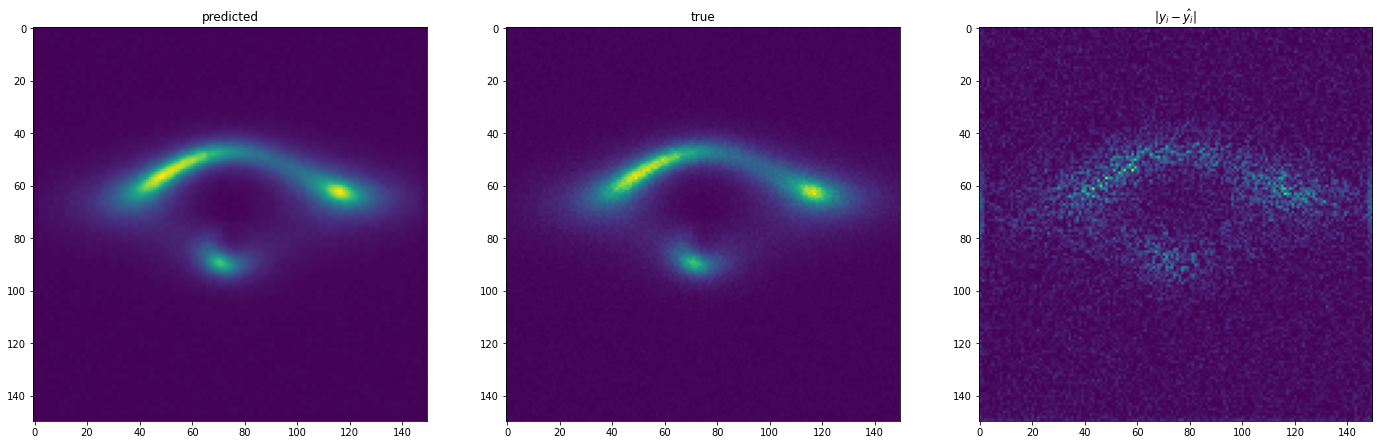

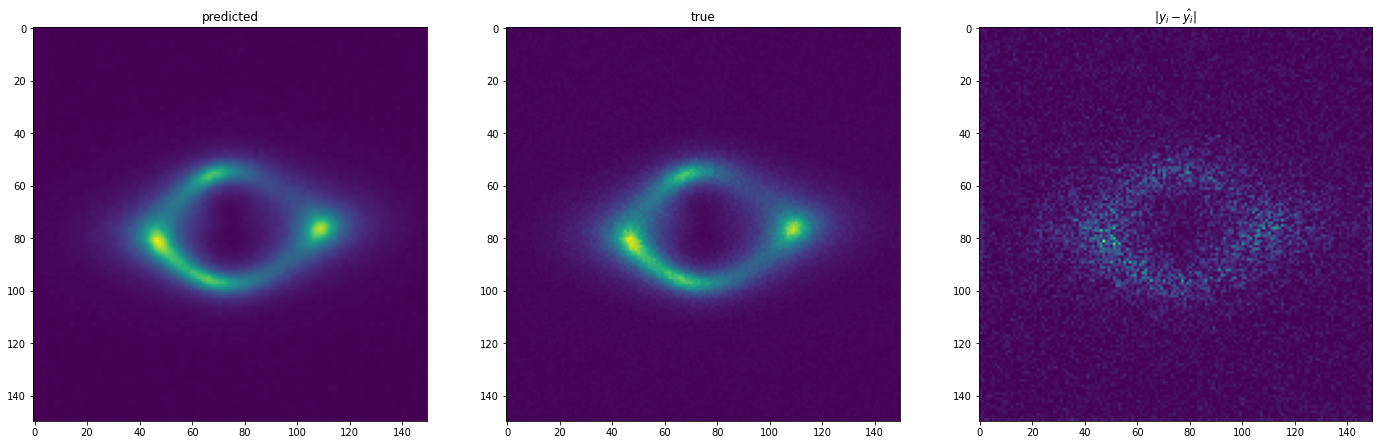

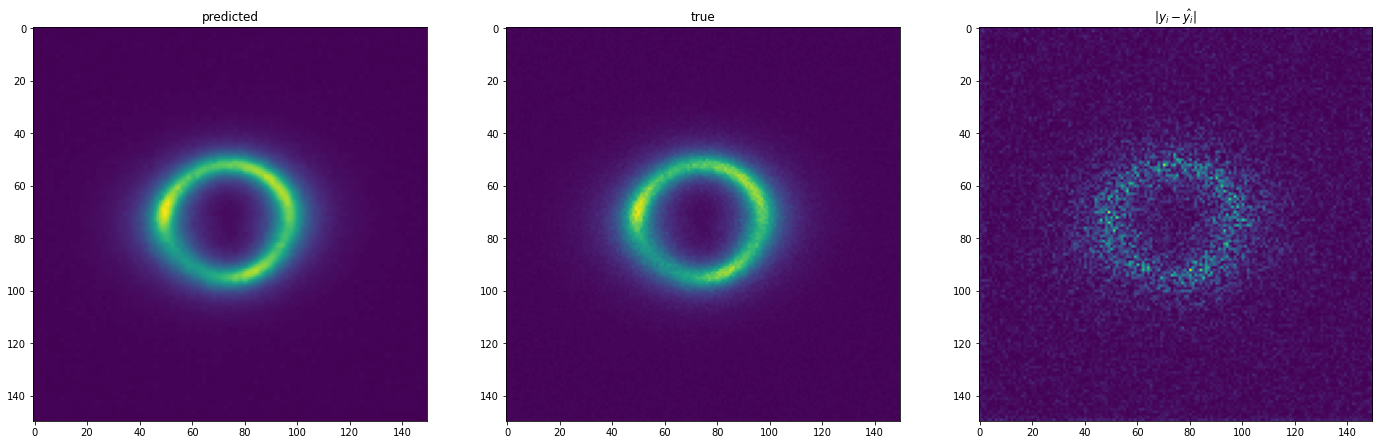

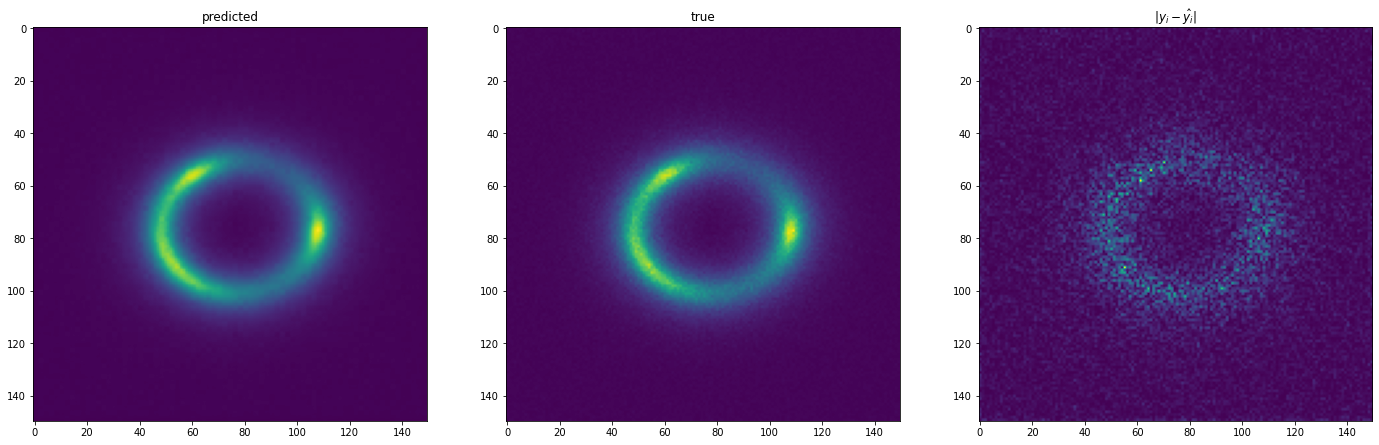

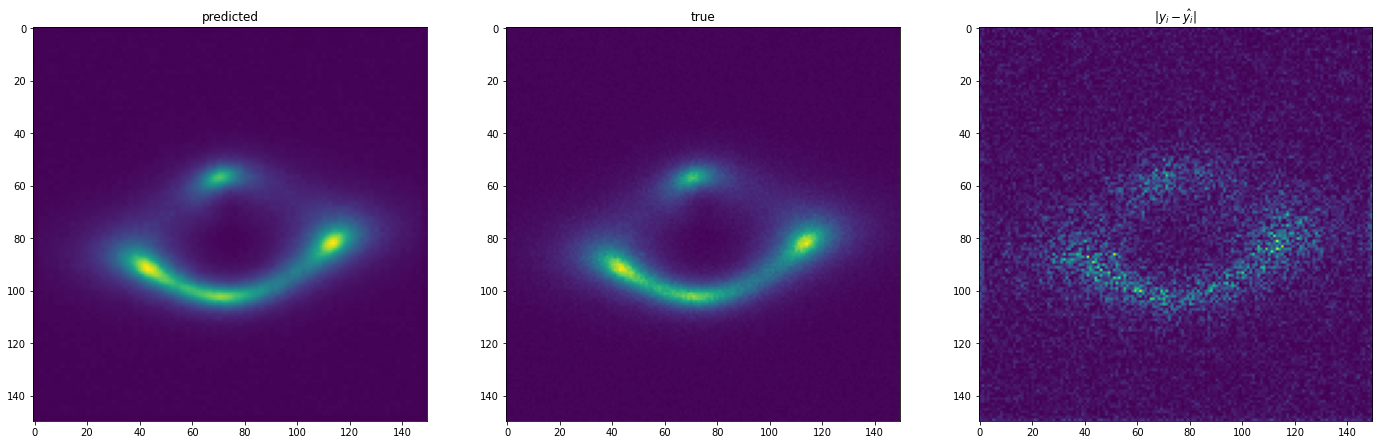

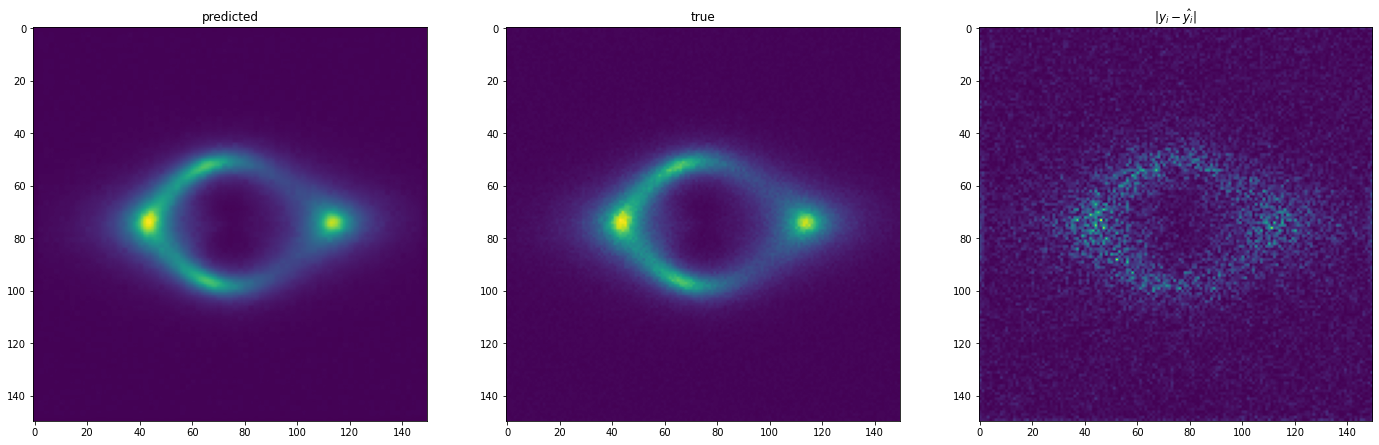

In [135]:
eval_model(model)

# SRGAN

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, PReLU, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Model

def build_generator(input_shape=(None, None, 3)):
    def res_block(x, filters):
        res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        res = BatchNormalization()(res)
        res = PReLU()(res)
        res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(res)
        res = BatchNormalization()(res)
        return Add()([x, res])

    input_img = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(input_img)
    x = x1 = PReLU()(x)

    for _ in range(5):
        x = res_block(x, 64)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x1, x])

    x = UpSampling2D()(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = PReLU()(x)

    #x = UpSampling2D()(x)
    #x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    #x = PReLU()(x)

    output_img = Conv2D(1, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    model = Model(inputs=input_img, outputs=output_img)
    return model

def build_discriminator(input_shape=(None, None, 3)):
    def conv_block(x, filters, strides):
        x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    input_img = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)

    x = conv_block(x, 64, 2)
    x = conv_block(x, 128, 1)
    x = conv_block(x, 128, 2)
    x = conv_block(x, 256, 1)
    x = conv_block(x, 256, 2)
    x = conv_block(x, 512, 1)
    x = conv_block(x, 512, 2)

    x = Conv2D(1024, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

# Build generator and discriminator
generator = build_generator(input_shape=(75, 75, 1))
discriminator = build_discriminator(input_shape=(150, 150, 1))

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy')

# Freeze the discriminator during the generator training phase
discriminator.trainable = False

# Create the combined model (generator followed by the discriminator)
input_lr = Input(shape=(75, 75, 1))
generated_hr = generator(input_lr)
validity = discriminator(generated_hr)

combined = Model(inputs=input_lr, outputs=[generated_hr, validity])
combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss=['mean_squared_error', 'binary_crossentropy'],
                 loss_weights=[1, 1e-3])


# 4. Train the SRGAN in an alternating manner
epochs = 20
batch_size = 16
patch_size = 10  # Patch size for the discriminator

real_labels = np.ones((batch_size, patch_size, patch_size, 1))
fake_labels = np.zeros((batch_size, patch_size, patch_size, 1))
i = 0
for epoch in range(epochs):
    for lr_batch, hr_batch in train_dataset:

      # Generate HR images using the generator
      generated_hr_batch = generator.predict(lr_batch)

      # Train the discriminator
      d_loss_real = discriminator.train_on_batch(hr_batch, real_labels)
      d_loss_fake = discriminator.train_on_batch(generated_hr_batch, fake_labels)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # Train the generator
      g_loss, _, _ = combined.train_on_batch(lr_batch, [hr_batch, real_labels])

      # Print the losses (optional)
      if i % 100 == 0:
          print("Epoch: %d, [Discriminator loss: %f] [Generator loss: %f]" % (epoch, d_loss, g_loss))

      i += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
Epoch: 4, [Discriminator loss: 0.000000] [Generator loss: 0.008992]
1/1 [==============================] - 0s 21ms/step
Epoch: 5, [Discriminator loss: 0.000000] [Generator loss: 0.053043]
1/1 [==============================] - 0s 20ms/step
Epoch: 5, [Discriminator loss: 0.000000] [Generator loss: 0.027129]
1/1 [==============================] - 0s 21ms/step
Epoch: 5, [Discriminator loss: 0.000000] [Generator loss: 0.044192]
1/1 [==============================] - 0s 22ms/step
Epoch: 5, [Discriminator loss: 0.000000] [Generator loss: 0.004727]
1/1 [==============================] - 0s 21ms/step
Epoch: 5, [Discriminator loss: 0.000000] [Generator loss: 0.005799]
1/1 [==============================] - 0s 29ms/step
Epoch: 6, [Discriminator loss: 0.000000] [Generator loss: 0.003479]
1/1 [==============================] - 0s 23ms/step
Epoch: 6, [Discriminator loss: 0.000000] [Generator loss:

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 43ms/step


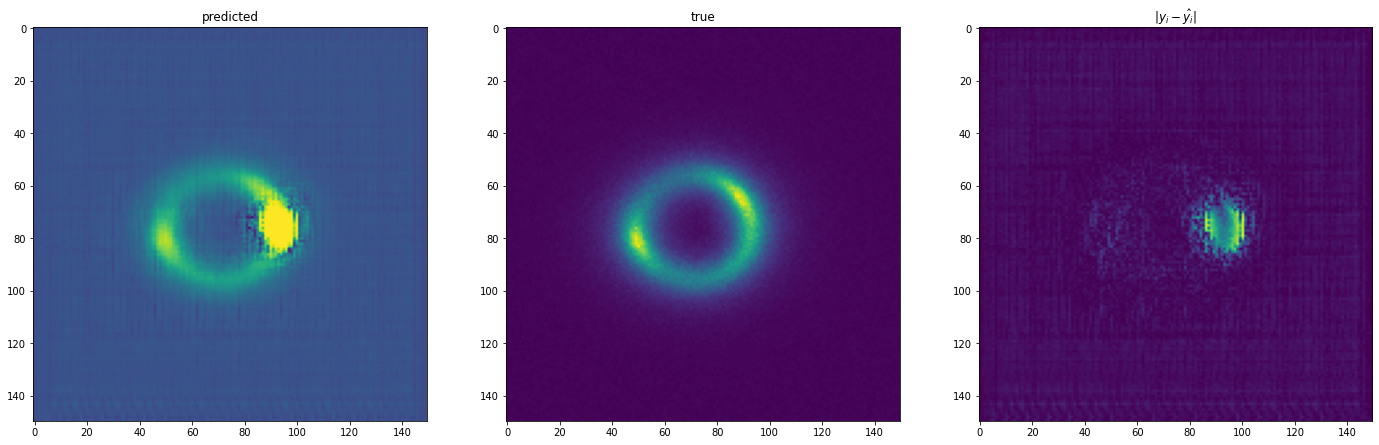

In [ ]:
eval_model(generator)